In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scvelo as scv
import torch
import os.path
sys.path.insert(1, '../')
import velovae as vv
%load_ext autoreload
%autoreload 2

In [3]:
adata_celltypes = ad.read_h5ad("smad_velocity_2k.h5ad")

In [10]:
adata_celltypes

AnnData object with n_obs × n_vars = 77455 × 1973
    obs: 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition', 'Cluster', 'clusters', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'Cluster_colors', 'clusters_colors', 'neighbors', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [11]:
dataset = "SMAD_2k"
model_path = f"checkpoints/{dataset}"
figure_path = f"figures/{dataset}"
data_path = f"data/{dataset}"
gene_plot = ["MAPT","VGF","CALM3","GAD1","SOX14","BCAN","PTPRZ1","TCF4","PEA15",
             "EBF2","CCNB1","CHD7","NOTCH1","MCM7","NEFL","GAP43"]

In [14]:
n_gene = 1973
vv.preprocess(adata_celltypes, n_gene)

Filtered out 5 genes that are detected 10 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:27) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.


In [15]:
torch.manual_seed(2022)
np.random.seed(2022)
rate_prior = {
    'alpha': (0.0, 1.0),
    'beta': (0.0, 0.5),
    'gamma': (0.0, 0.5)
}
full_vb = vv.VAE(adata_celltypes, 
                 tmax=20, 
                 dim_z=5, 
                 device='cuda:0',
                 full_vb=True,
                 rate_prior=rate_prior)

Estimating ODE parameters...


  0%|          | 0/1968 [00:00<?, ?it/s]

Detected 658 velocity genes.
Estimating the variance...


  0%|          | 0/1968 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/1968 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 1350, repression: 618/1968


In [16]:
full_vb.train(adata_celltypes,
              plot=False,
              gene_plot=gene_plot,
              figure_path=figure_path,
              embed="umap")

Learning Rate based on Data Sparsity: 0.0005
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 424, test iteration: 846
*********       Stage 1: Early Stop Triggered at epoch 52.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/77455 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 1556
*********     Round 1: Early Stop Triggered at epoch 86.    *********
Change in noise variance: 0.2388
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 114.    *********
Change in noise variance: 0.0001
Change in x0: 0.1492
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 128.    *********
Change in noise variance: 0.0000
Change in x0: 0.1223
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 148.    *********
Change in noise variance: 0.0000
Change in x0: 0.1091
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 174.    *********
Change in noise variance: 0.0000
Change in x0: 0.0998
*********             Velocity Refinement Round 6   

In [18]:
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata_celltypes, 'fullvb', data_path, file_name="smad_2k.h5ad")

In [26]:
adata_celltypes.obs["clusters"] = adata_celltypes.obs["cell_type"]

Computing velocity embedding using scVelo
computing velocity graph (using 36/36 cores)


  0%|          | 0/77455 [00:00<?, ?cells/s]

    finished (0:03:11) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:20) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 36/36 cores)


  0%|          | 0/77455 [00:00<?, ?cells/s]

    finished (0:08:19) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:20) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 77455 cells, 1968 genes
---   Plotting  Results   ---
computing velocity graph (using 36/36 cores)


  0%|          | 0/77455 [00:00<?, ?cells/s]

    finished (0:07:54) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:20) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/SMAD_2k_finalized_v4_run2/continuous_fullvb_stream.png


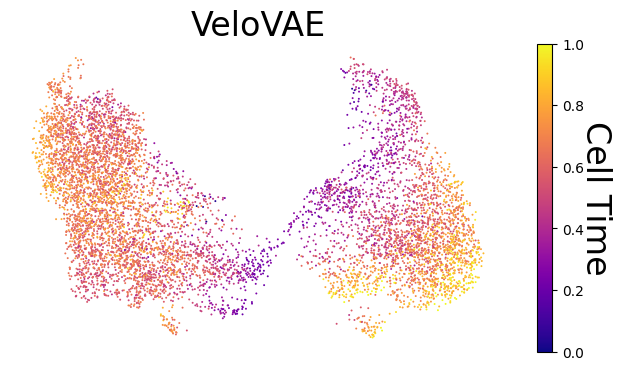

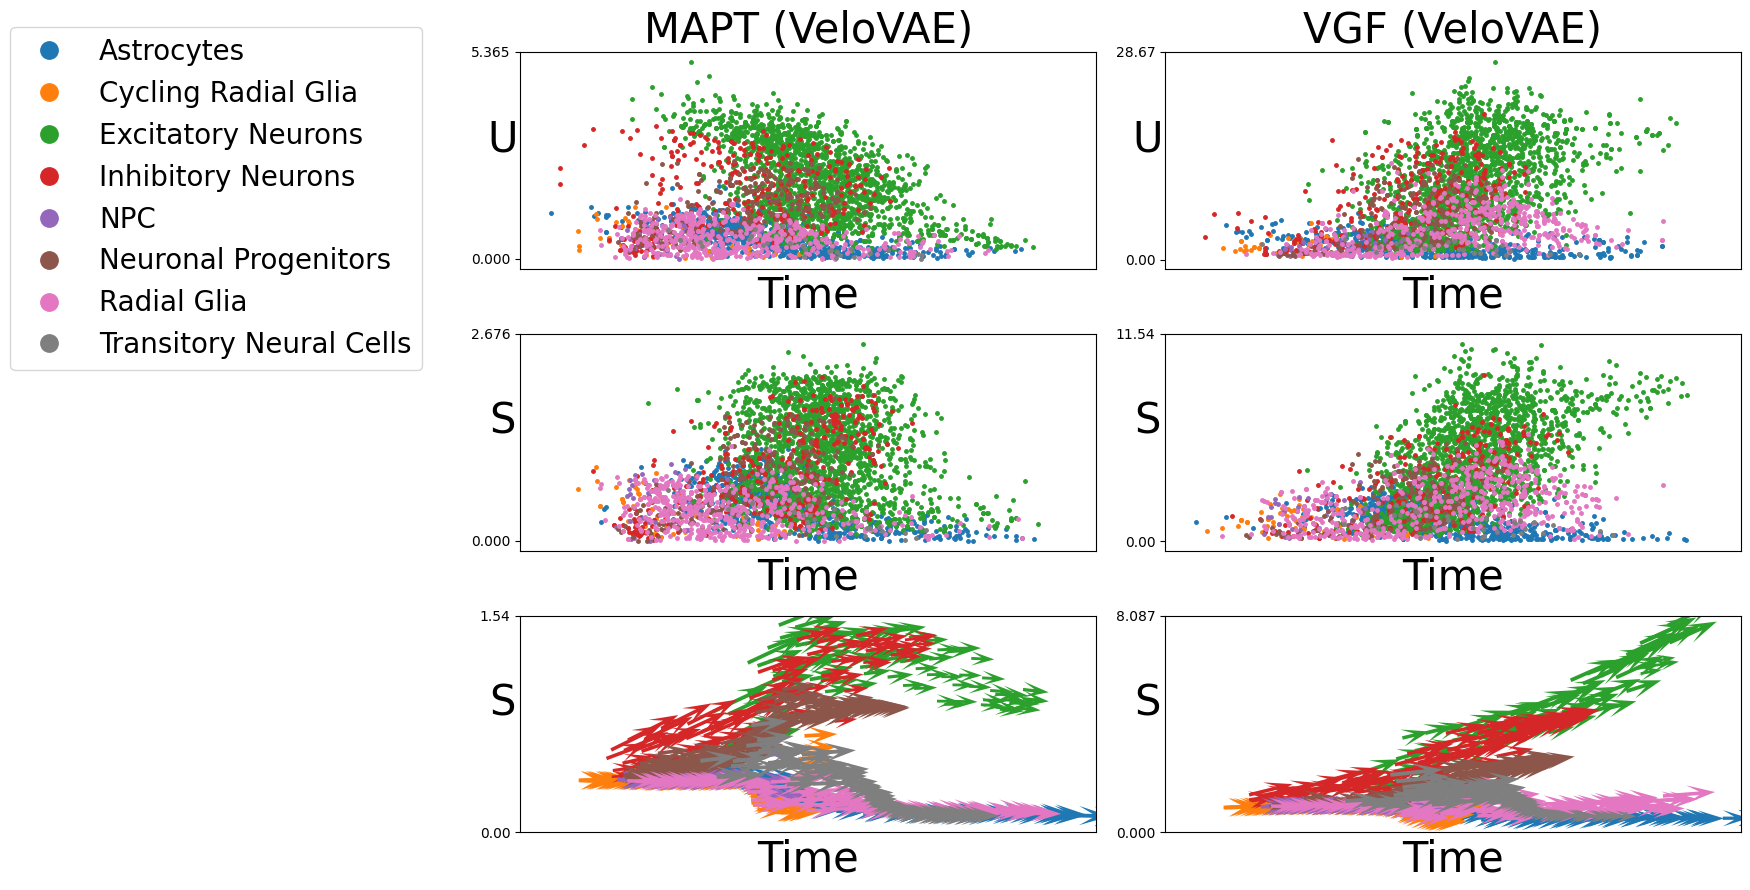

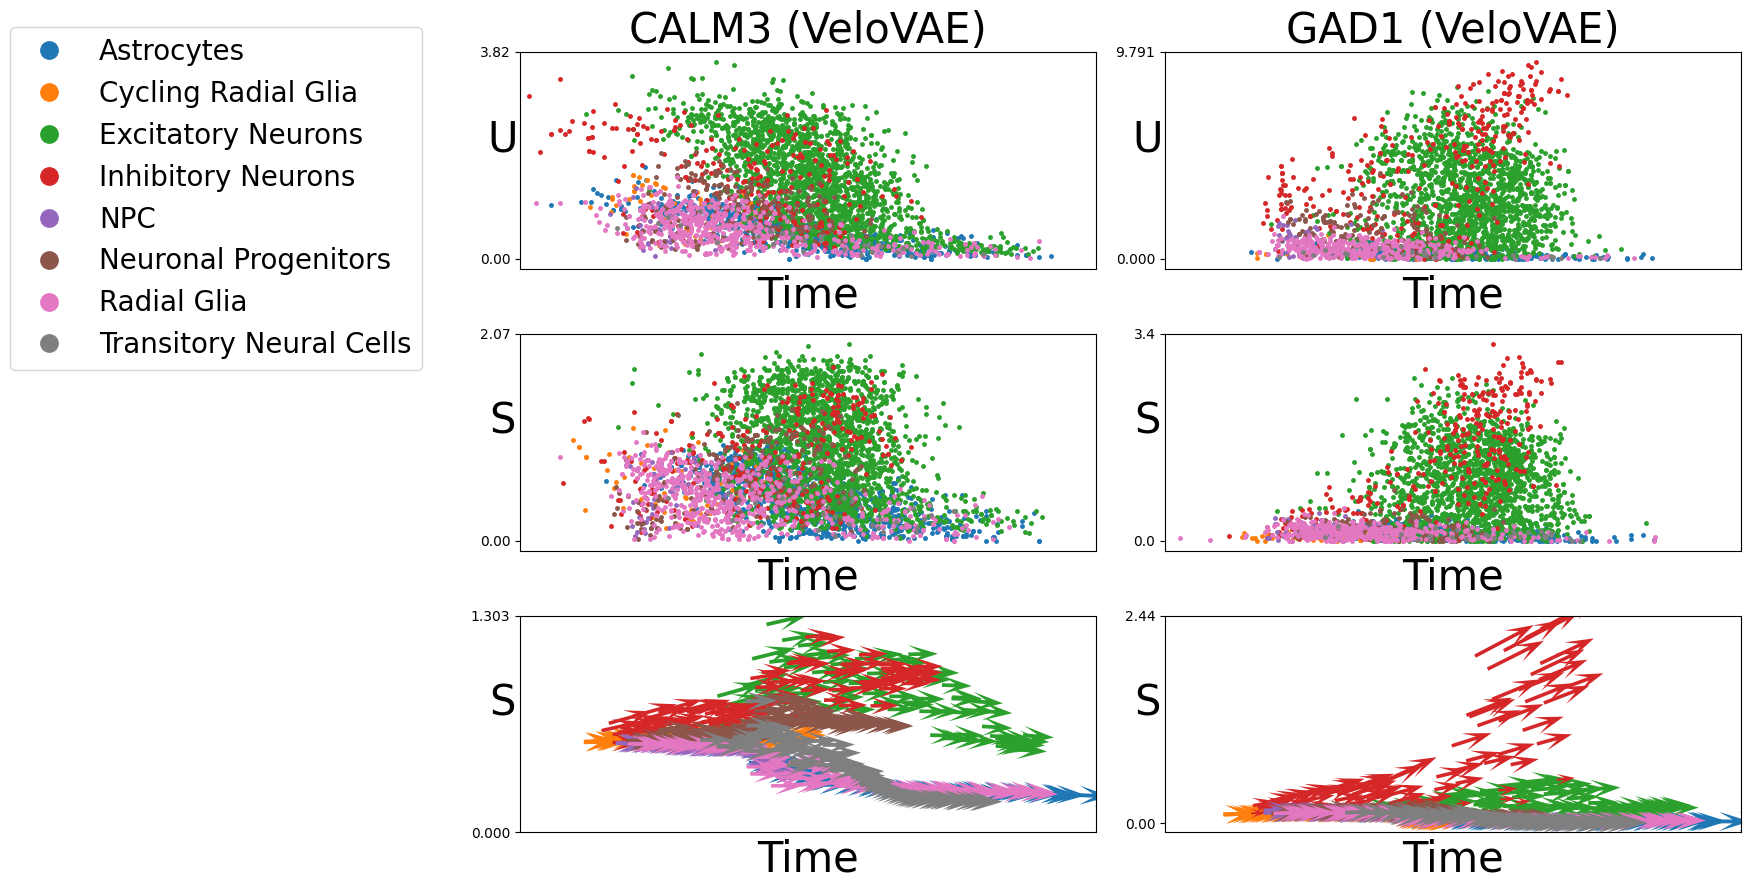

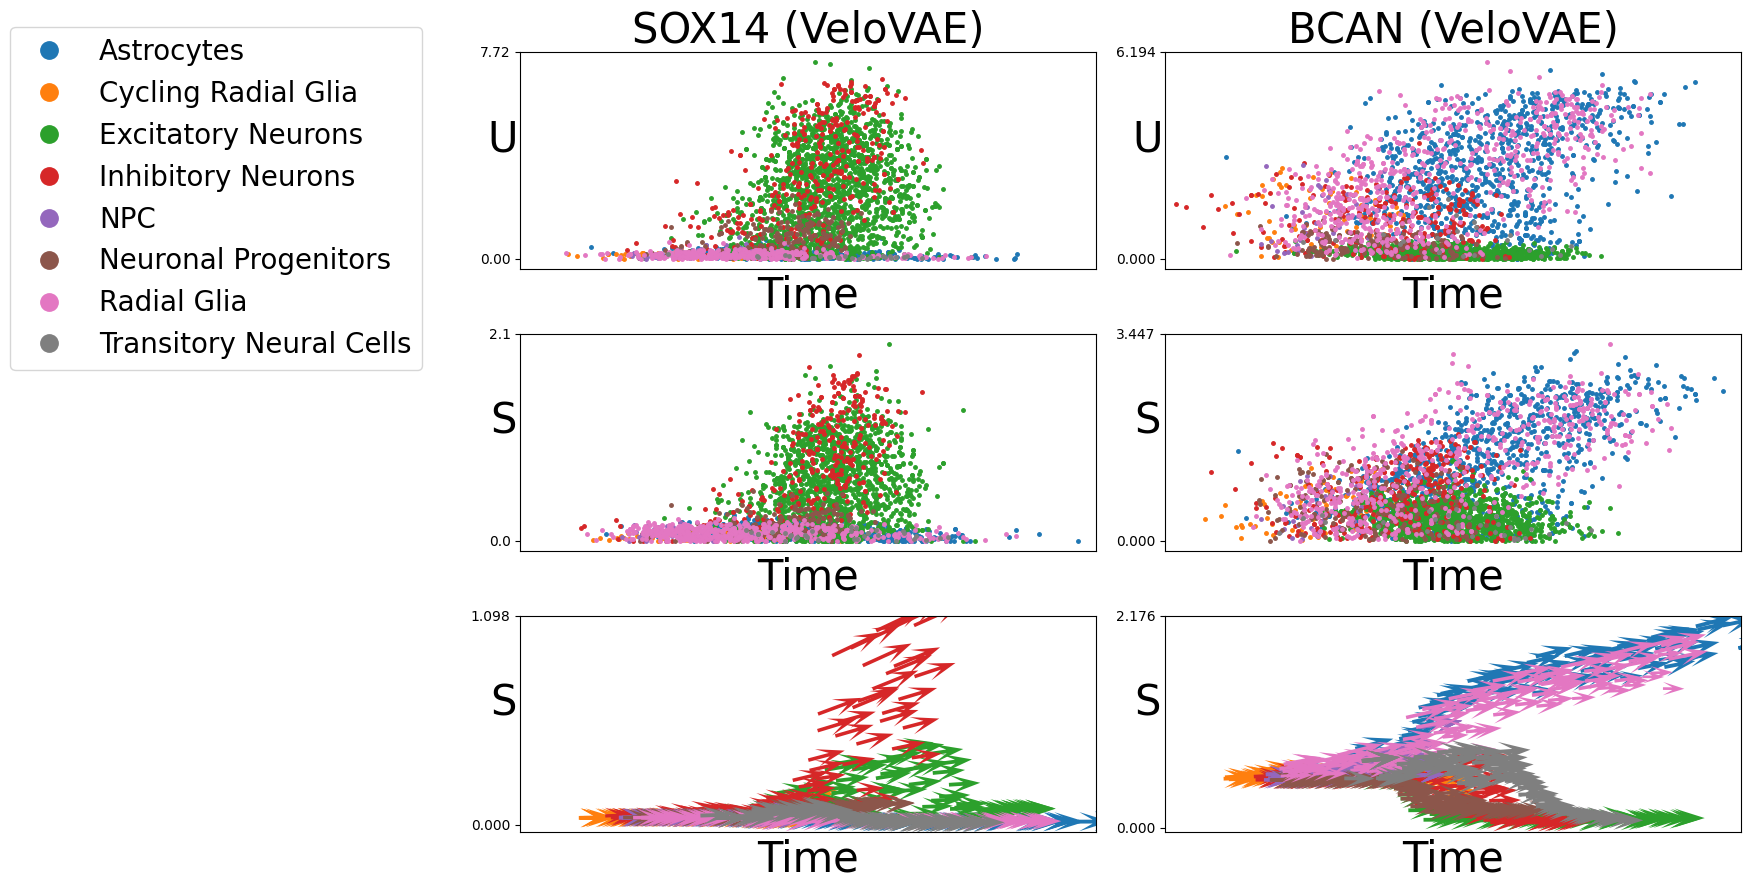

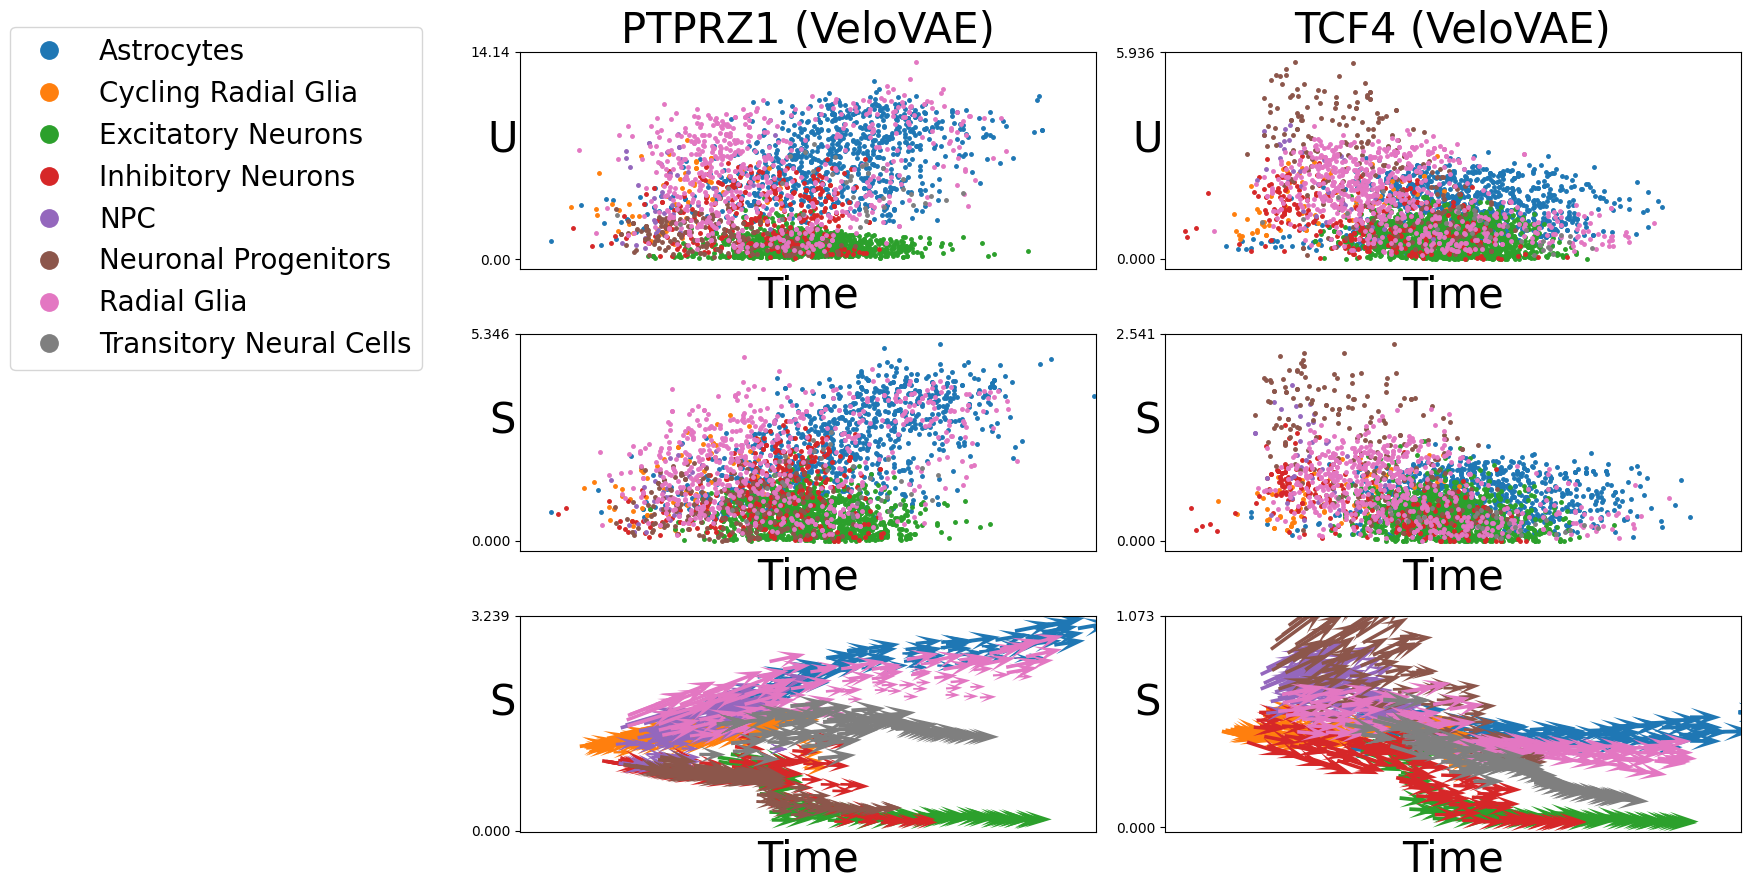

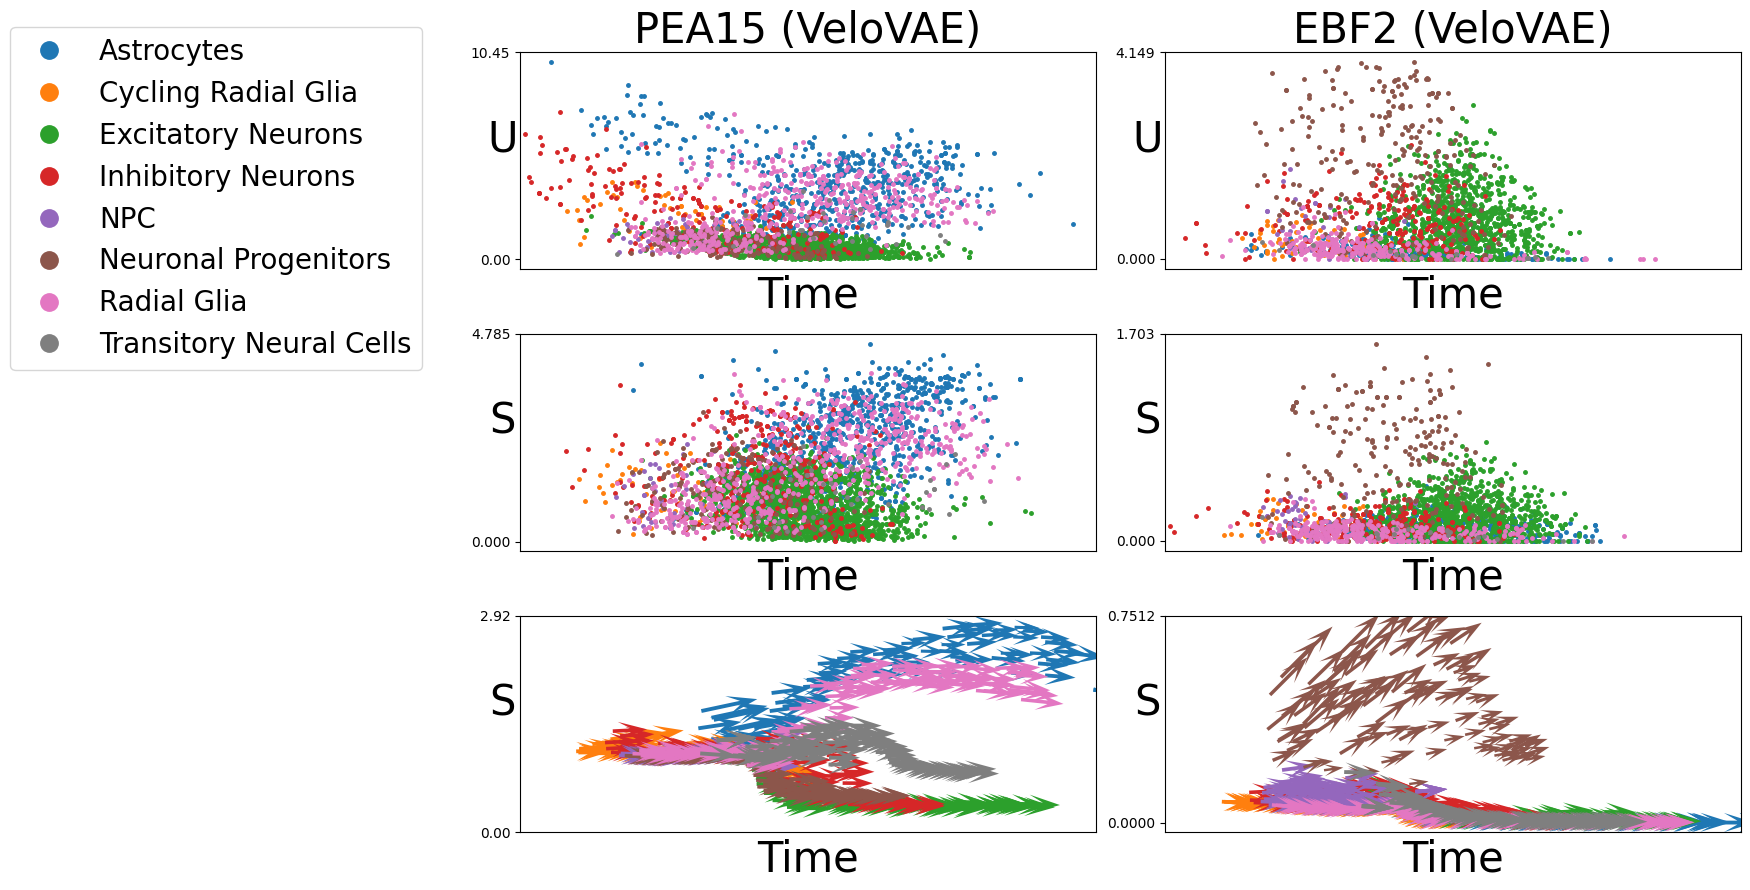

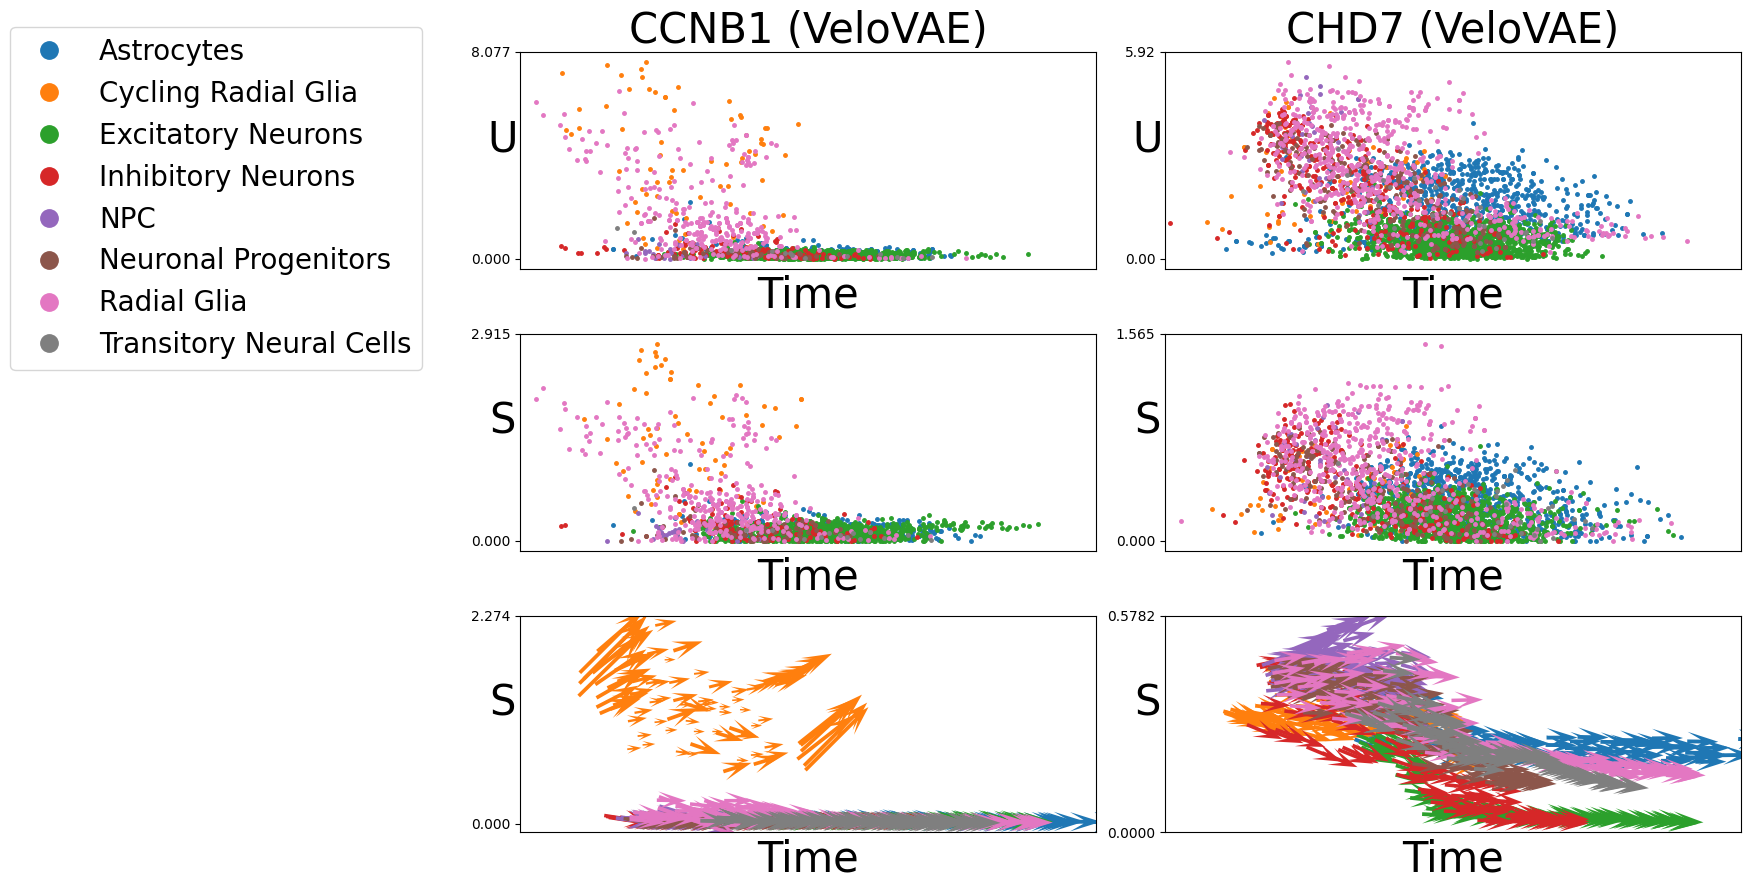

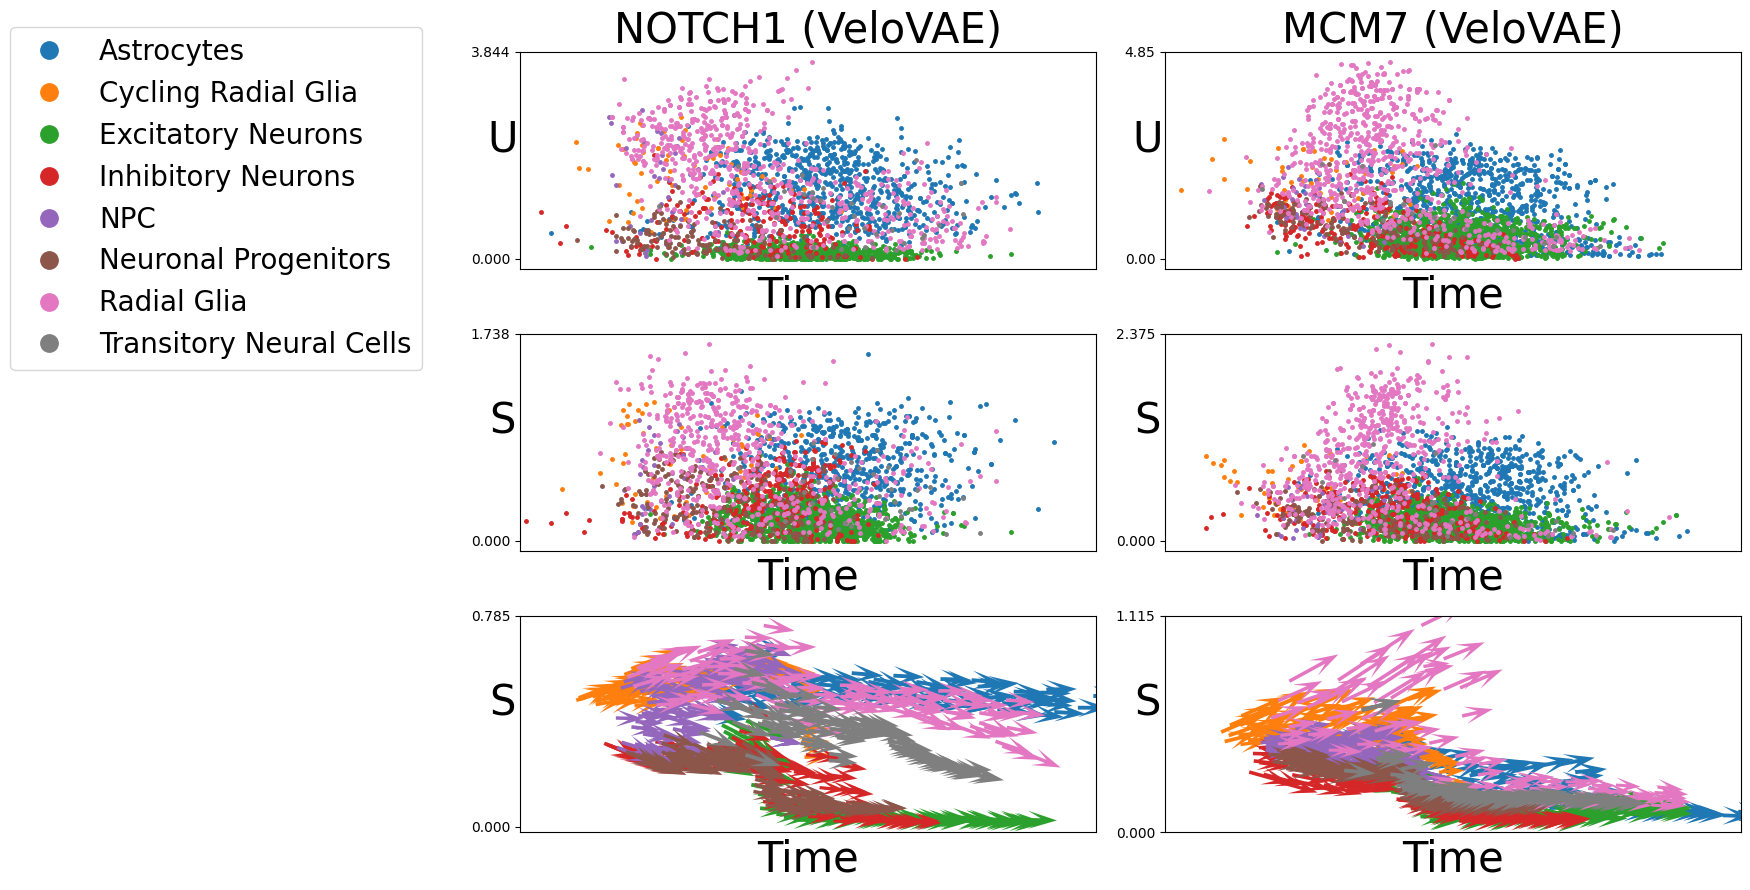

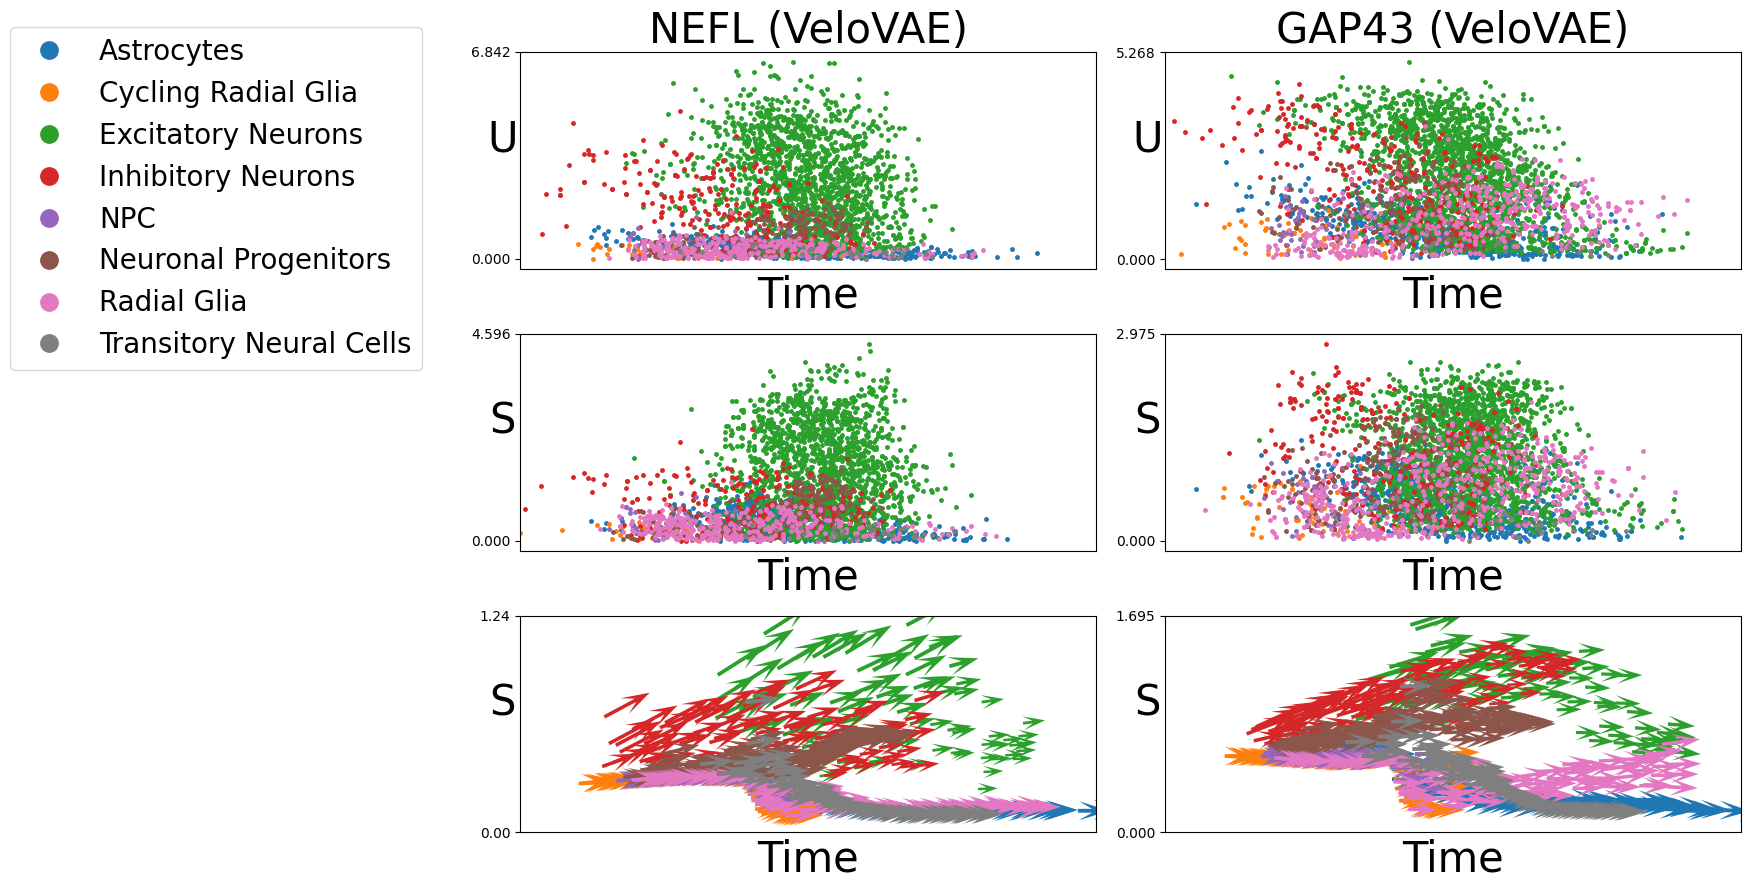

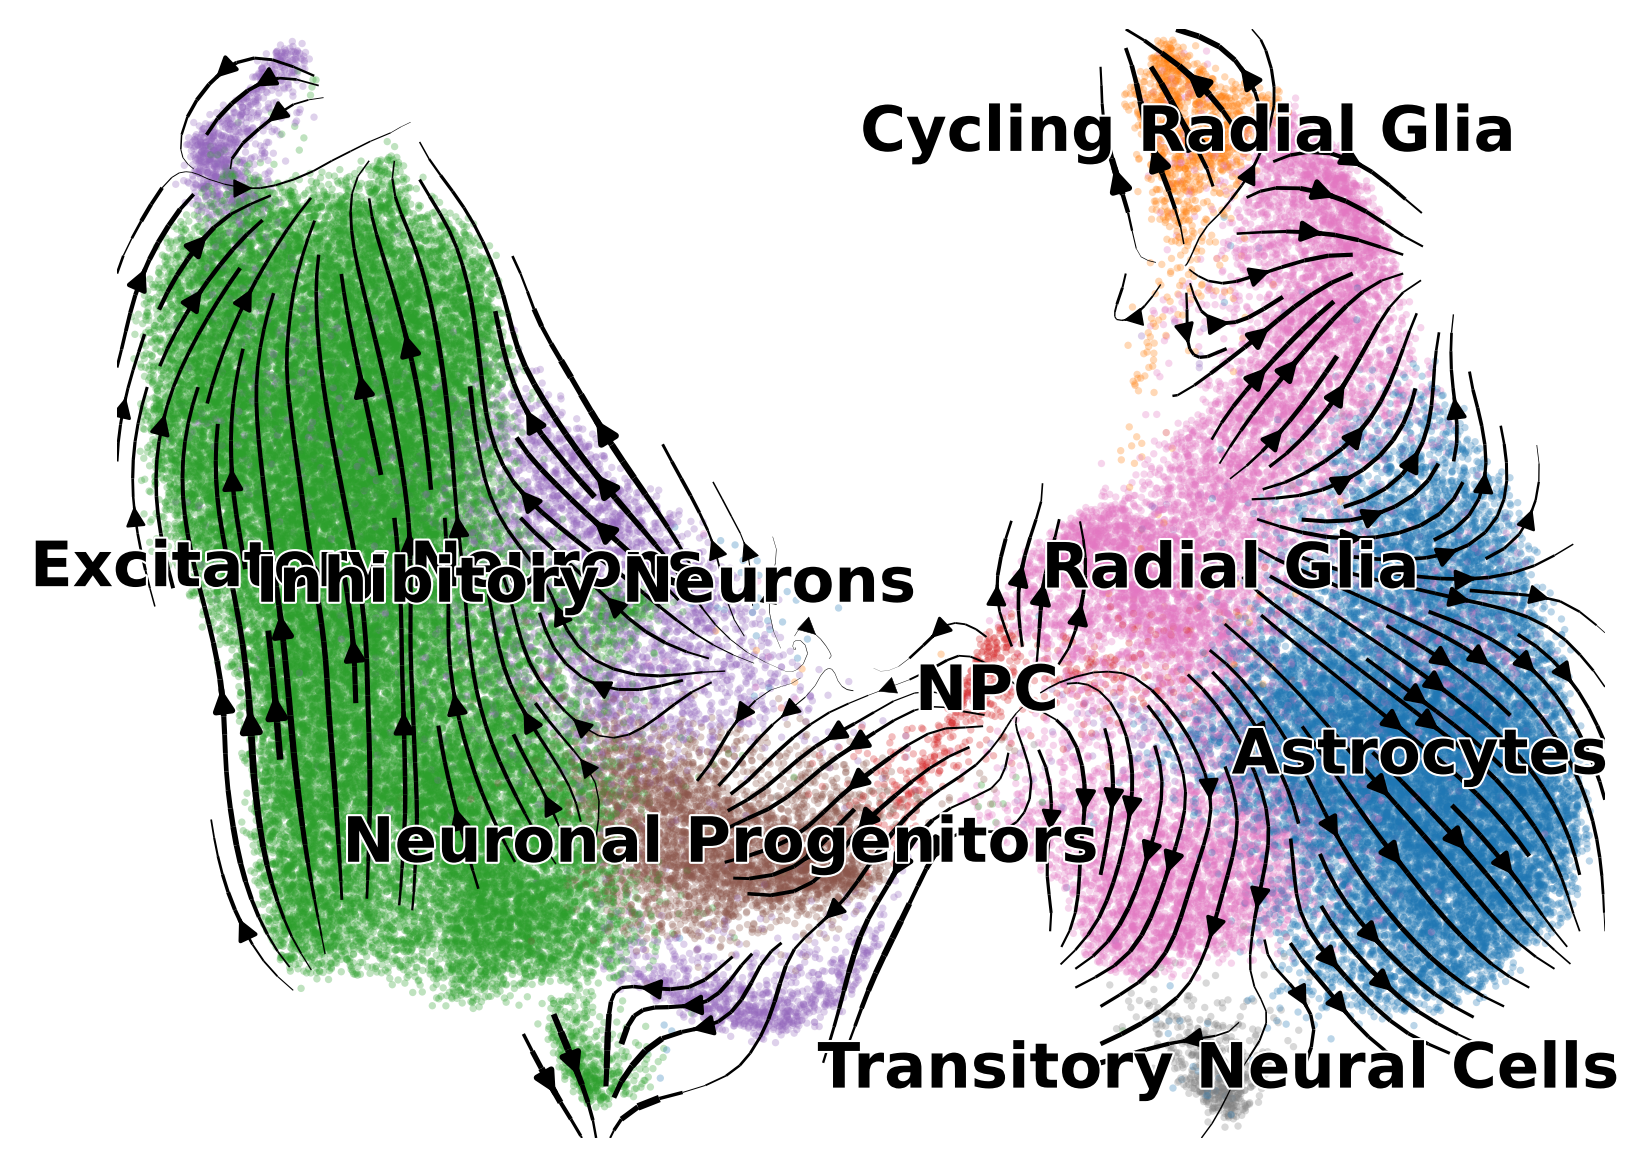

In [18]:
cluster_edges = [('NPC', 'Radial Glia'),
                 ('NPC', 'Neuronal Progenitors'),
                 ('Radial Glia', 'Astrocytes'),
                 ('Radial Glia', 'Transitory Neural Cells'),
                 ('Astrocytes', 'Transitory Neural Cells'),
                 ('Neuronal Progenitors', 'Inhibitory Neurons'), 
                 ('Neuronal Progenitors', 'Excitatory Neurons')]
methods = ['FullVB']
keys = ['fullvb']
grid_size = (1,2)
res, res_type = vv.post_analysis(combined_adata,
                                 'continuous',
                                 methods,
                                 keys,
                                 compute_metrics=True,
                                 raw_count=False,
                                 genes=gene_plot,
                                 grid_size=(1,2),
                                 figure_path=figure_path,
                                 cluster_edges=cluster_edges)